In [17]:
# Imports as always
import pandas as pd
import numpy as np

from pathlib import Path
import os
import re

import urllib.request
from PIL import Image, ImageStat
import io

from scipy.ndimage import laplace, gaussian_filter
import matplotlib.pyplot as plt

# Inferring Information from Images

A good article about measuring attributes of images is that of Marian Stefanescu. [[Ref]](https://towardsdatascience.com/measuring-enhancing-image-quality-attributes-234b0f250e10)

In [3]:
images = pd.read_csv('datasets/listings_edinburgh.csv')[['id', 'picture_url']]

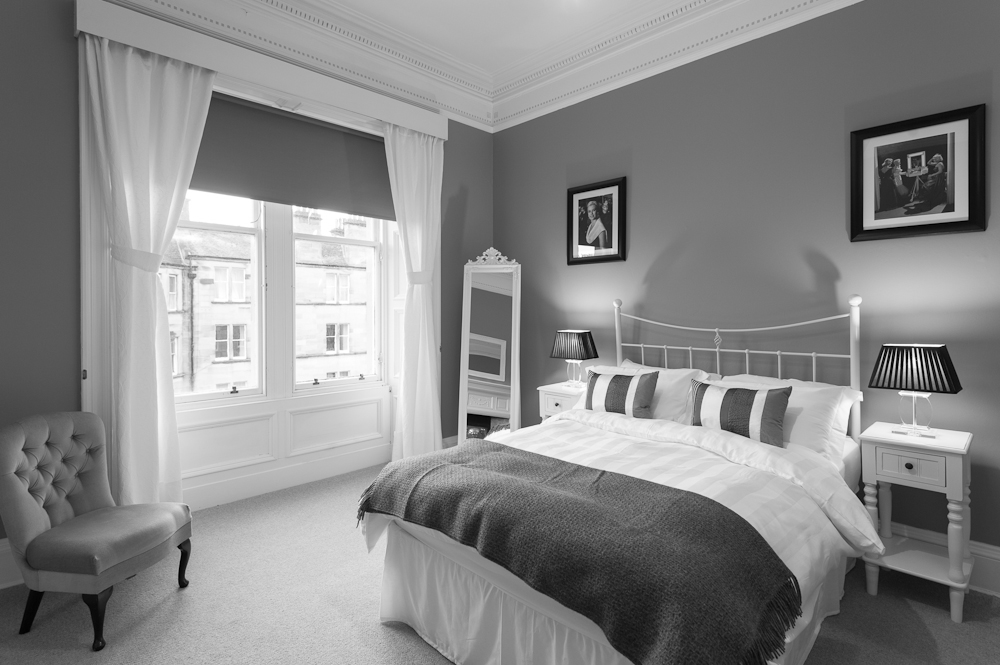

In [4]:
# Download the image from the URL.
image_data = urllib.request.urlopen(images.picture_url.values[16]).read()

# Convert the image to greyscale.
image_grey = Image.open(io.BytesIO(image_data)).convert('L')
image_grey

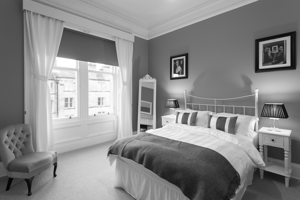

In [5]:
# Get the width:height ratio of the image so that it can be maintained in resizing.
width, height = image_grey.size
aspect_ratio = width / height

resolution = 200

# Downsample the image to speed up processing.
image_grey_resized = image_grey.resize((int(resolution * aspect_ratio), resolution))
image_grey_resized

## Brightness/Exposure

A simple measure for brightness is the average pixel value (i.e. the mean greyscale value).

In [6]:
brightness = np.mean(image_grey_resized)

print('Value Mean (i.e. brightness):', brightness)

Value Mean (i.e. brightness): 136.92085


## Contrast (Global vs. Local)

One recommended method for measuring the contrast in an image is to look at the standard deviation of the pixel values (i.e. their greyscale value) away from the mean. [[Ref]](https://stackoverflow.com/questions/61658954/measuring-contrast-of-an-image-using-python)

Looking at the difference between the lowest and greatest values may be ineffective as most images contain the majority of the range (0 to 255).

In [7]:
stats = ImageStat.Stat(image_grey_resized)

print('Value range:', stats.extrema[0])
print('Value Std (i.e. Contrast):', stats.stddev[0])

Value range: (1, 255)
Value Std (i.e. Contrast): 54.780288291296


Another idea is to use a Laplacian filter on the image to accentuate the edges in the image [[Ref]](https://iq.opengenus.org/laplacian-filter/). We can then sum the absolute values of the filtered image to infer contrast. This is a rougher estimate of the contrast the considers perceivable edges as a measure for contrast rather than wider pixel values.

You may perceive this to be a rough and *local* measure for contrast, with the standard deviation method being a smooth and *non-local* measure that considers the whole image at once.

Text(0.5, 1.0, 'Gaussian + Laplacian')

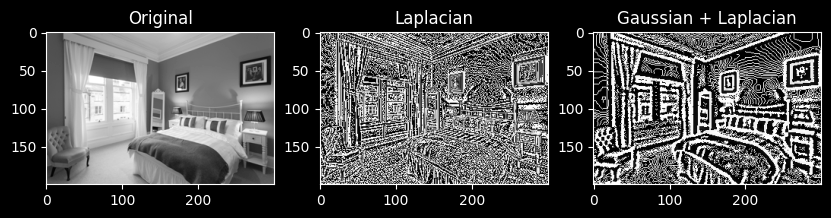

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(10,4))
plt.gray()

# Apply a Laplacian filter (for edges). 
image_laplace = laplace(image_grey_resized)

# Apply a Gaussian filter (for smoothing) followed by a Laplacian filter (for edges).
image_gauss_laplace = laplace(gaussian_filter(image_grey_resized, sigma=1.5))

# Show the images...

axes[0].imshow(image_grey_resized)
axes[1].imshow(image_laplace)
axes[2].imshow(image_gauss_laplace)

axes[0].set_title('Original')
axes[1].set_title('Laplacian')
axes[2].set_title('Gaussian + Laplacian')

The image of the accentuated edges very clearly shows the edges as bright lines. However, there are lots of dim mazes that do not capture edges but contribute to the contrast all the same. Since they probably should not, we can set a threshold brightness in this filtered image to only consider the edges.

These dim mazes are in fact just thin lines of full brightness, and so we will set any pixel that is too bright to 0, and leave everything else, which has the effect of only retaining the edges (which have a larger clump of pixels, most of which are not full brightness).

Text(0.5, 1.0, 'Threshold of >252')

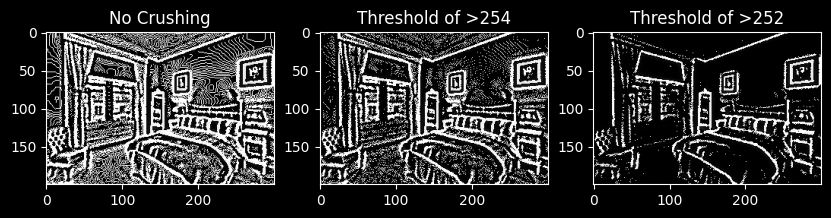

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(10,4))
plt.gray()

# Neglect all pixel values below a threshold.
image_crushed_A = image_gauss_laplace.copy()
image_crushed_A[image_crushed_A > 254] = 0

image_crushed_B = image_gauss_laplace.copy()
image_crushed_B[image_crushed_B > 252] = 0

# Show the images...

axes[0].imshow(image_gauss_laplace)
axes[1].imshow(image_crushed_A)
axes[2].imshow(image_crushed_B)

axes[0].set_title('No Crushing')
axes[1].set_title('Threshold of >254')
axes[2].set_title('Threshold of >252')

In [10]:
print('Mean of Accentuated Edges (i.e. Mean of Local Contasts)...')
print('Threshold >254:', np.mean(image_crushed_A))
print('Threshold >252:', np.mean(image_crushed_B))

Mean of Accentuated Edges (i.e. Mean of Local Contasts)...
Threshold >254: 73.56781666666667
Threshold >252: 36.14375


## Colour

We'll take the mean and standard deviation of each colour channel -- why not!

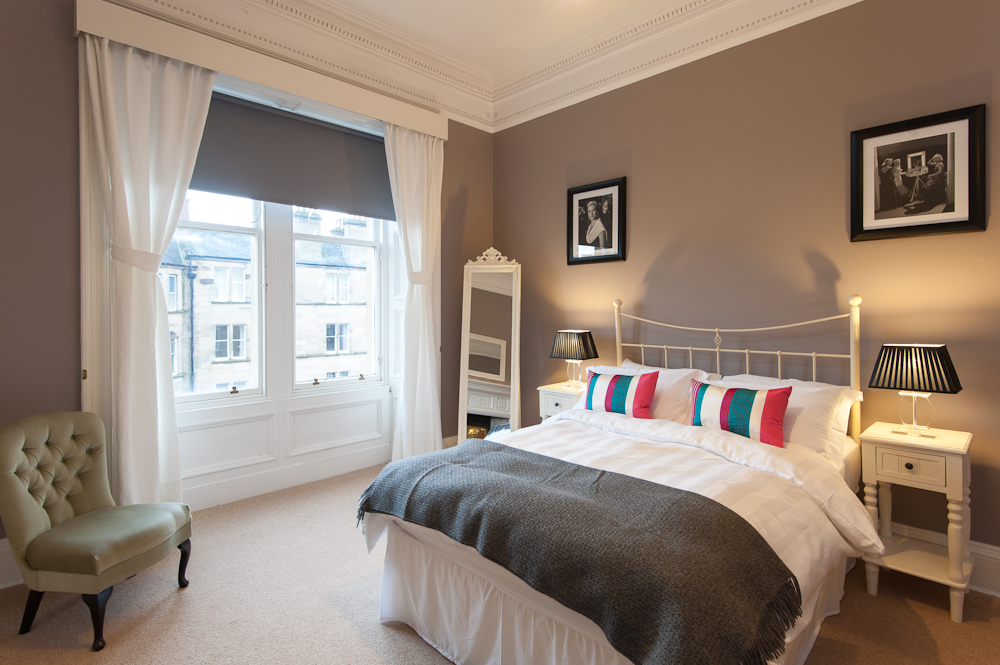

In [11]:
# Convert the image to RGB.
image_colour = Image.open(io.BytesIO(image_data)).convert('RGB')
image_colour

In [12]:
image_colour_resized = image_colour.resize((int(resolution * aspect_ratio), resolution))

In [13]:
stats = ImageStat.Stat(image_colour_resized)

width, height = image_colour_resized.size
total_pixels = width * height

for band, name in enumerate(image_colour_resized.getbands()): 
    print(f'Band: {name}, min/max: {stats.extrema[band]}, sum: {stats.sum[band] / total_pixels}, stddev: {stats.stddev[band]}')

Band: R, min/max: (0, 255), sum: 150.12498333333335, stddev: 52.96388702848752
Band: G, min/max: (1, 255), sum: 133.42215, stddev: 56.10857753241329
Band: B, min/max: (0, 255), sum: 120.30166666666666, stddev: 59.44999493038013


## Learning Successful Images with CNNs

To save time in reading images, we will download and downsample the images to store them locally on disk.

In [16]:
# Note: for ~7400 images, this takes ~50 minutes.

# Target size.
target_size = (256, 256)

# Create the directory if it does not yet exist.
directory = f'images/edinburgh/{target_size[0]}x{target_size[1]}'
if not os.path.exists(directory):
    os.makedirs(directory)

    # Download all of the images onto the disk.
    images = pd.read_csv('datasets/listings_edinburgh.csv')[['id', 'picture_url']]

    for i in range(len(images)):
        print(f'{i}/{len(images)} = {round((i / len(images) * 100), 2)}%')

        try:
            # Download the image from the URL.
            image = urllib.request.urlopen(images.picture_url.values[i]).read()

            # Convert the image to greyscale.
            image = Image.open(io.BytesIO(image)).convert('L')

            # Downsample.
            image = image.resize(target_size)

            # Save the image. 
            image.save(f'{directory}/{images.id.values[i]}.jpg')

        except:
            print('Could not save', images.picture_url.values[i])

else:
    print('Directory already exists.')

Directory already exists.


Let's now train a regression CNN based on the single-channel 256x256 images.

In [42]:
# Get a list of all the image files in the folder.
img_folder = 'images/edinburgh/256x256/'
file_names = os.listdir(img_folder)

# Get a list of all the ids in the image folder.
present_ids = []
for file_name in file_names:
    match = re.search(r'(\d+)\.jpg', file_name)

    if match:
        present_ids.append(int(match.group(1)))

# Read in the success scores for the present ids.
success_scores = pd.read_csv('datasets/master_edinburgh.csv')[['id', 'success_score']]
success_scores = success_scores[success_scores.id.isin(present_ids)]

In [44]:
# How many NaN values we got?
success_scores.isna().sum()

id                 0
success_score    630
dtype: int64

In [45]:
# Remove all Nan values in the success score.
success_scores = success_scores.dropna()

In [71]:
from sklearn.preprocessing import StandardScaler

# Normalise the success scores.
scalar = StandardScaler()

to_normalise = success_scores.success_score.values.reshape(-1, 1)
normalised = scalar.fit_transform(to_normalise)

success_scores.success_score = normalised

c:\Users\bwpri\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
82/82 [==============================] - 93s 1s/step - loss: 1105908.2500 - val_loss: 2.7710
Epoch 2/5
82/82 [==============================] - 93s 1s/step - loss: 1.4810 - val_loss: 0.9424
Epoch 3/5
82/82 [==============================] - 94s 1s/step - loss: 1.0537 - val_loss: 0.8213
Epoch 4/5
82/82 [==============================] - 96s 1s/step - loss: 0.8807 - val_loss: 0.8252
Epoch 5/5
62/62 [==============================] - 8s 131ms/step
Final model metrics... MAE: 0.632, MSE: 0.681, R2 Score: 0.314


<AxesSubplot: >

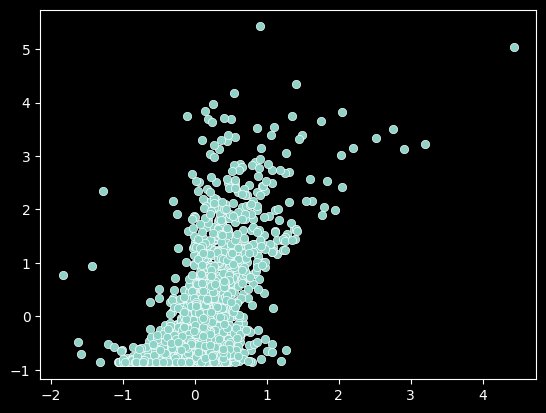

In [73]:
from sklearn.model_selection import train_test_split

# Imports necessary for this model.
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set the input shape for the model
input_shape = (256, 256, 1)

# Define the model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))

# Loop through each image and its corresponding score in the dataframe
X = []
y = []
for i in range(len(success_scores)):
    img_path = os.path.join(img_folder, str(success_scores.id.values[i]) + '.jpg')
    img = Image.open(img_path)
    img_arr = np.asarray(img)
    X.append(img_arr.reshape(input_shape))
    y.append(success_scores.success_score.values[i])

# Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

# Train the model
model.fit(X, y, batch_size=64, epochs=5, validation_split=0.2)

# Report the final metrics.
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
r2 = r2_score(y_true=y_test, y_pred=y_pred)

print(f'Final model metrics... MAE: {round(mae, 3)}, MSE: {round(mse, 3)}, R2 Score: {round(r2, 3)}')

# Visualise how good the model is.
import seaborn
seaborn.scatterplot(x=[float(i) for i in y_pred], y=[i for i in y_test])

Whether these results look good or bad is not really all that helpful, for they are *almost entirely random*. We need more images, and we need more evidence of correlation. If adding more data reduces the fluctation in results, then we can be more confident that images are relevant to the success. With the present amount (<7000), it is hard to say.